In [1]:
import psutil

def get_free_memory():
    memory = psutil.virtual_memory()
    return memory.available / (1024.0 ** 3)  # Convert bytes to gigabytes

print(f"Free CPU Memory: {get_free_memory():.2f} GB")

Free CPU Memory: 663.47 GB


In [2]:
import torch
torch.backends.cuda.matmul.allow_tf32 = True
from datasets import Dataset
import os

In [3]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import WhitespaceSplit

tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
tokenizer.pre_tokenizer = WhitespaceSplit()

In [4]:
tokenizer_path = "WordLevel_tokenizer_trained_InterPro.json"
tokenizer = tokenizer.from_file(tokenizer_path)
tokenizer.enable_truncation(512)

In [5]:
tokenizer.get_vocab_size()


544998

In [6]:
test = tokenizer.encode("WP_265490204 WP_206642677 WP_053312998 WP_251959347 WP_000076573 WP_227526754 WP_218401808 WP_106925592")
test.ids

[1, 2966, 754, 2545, 196, 9231, 2817, 7418, 2526, 2]

In [7]:
import csv

defense_ips = []
directory = "/home/toibazd/Secretion_InterPros/"
file_list = os.listdir(directory)

for file in file_list:
    print(file)
    file_path = os.path.join(directory, file)
    with open(file_path, 'r', newline='') as infile:
        reader = csv.reader(infile, delimiter = "\t")
        next(reader)
        for row in reader:
            ip = row[0]
            defense_ips.append(ip)

secretion_IP.tsv


In [8]:
print("Secretion IPs number: ", len(defense_ips))

Secretion IPs number:  164


In [9]:
from collections import defaultdict
import csv
from tqdm.auto import tqdm
import numpy as np

data_dict = defaultdict(list)

with open("/home/toibazd/Prot2IP.tsv", "r") as tsvfile:
    reader = csv.reader(tsvfile, delimiter = "\t")
    for row in tqdm(reader):
        key = row[0].split("prot_")[1].split(".")[0]
        iprs = eval(row[1])

        # Save only if there are filtered InterPro IDs
        for ip in iprs:
            if ip in defense_ips:
                data_dict[key].append(ip)


0it [00:00, ?it/s]

In [10]:
unique_defense = set()

# Iterate through each value list in the dictionary and add its elements to the set
for value_list in data_dict.values():
    unique_defense.update(value_list)

# Convert the set to a list if needed
unique_defense = list(unique_defense)

In [11]:
len(unique_defense)

156

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer
enc = MultiLabelBinarizer()
one_hot_encoded = enc.fit_transform(data_dict.values())
one_hot_encoded_dict = {key: value for key, value in zip(data_dict.keys(), one_hot_encoded)}

print(len(one_hot_encoded_dict.keys()))

4161


In [13]:
one_hot_encoded.shape

(4161, 156)

In [14]:
import os
import random
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

directory = '/ibex/user/toibazd/InterPro/'
one_hot_encoded_sentences = {}

sentence_length = 9
sentences_per_IP = 200

# Set random seed for reproducibility
random.seed(42)

# Randomly choose 1000 files with seed 42
selected_files = os.listdir(directory)


# Define a function to process a file
def process_file(filename, IP):
    sentences = []

    filepath = os.path.join(directory, filename)

    with open(filepath, 'r') as file:
        content = file.read()
        words = content.strip().split()

        # Check if the key is in the file
        for i in range(4, len(words)-4):
            # Shuffle the indices of the words containing the key
            if IP in data_dict[words[i]]:
                if len(words) - i >= 4:
                    sentence = " ".join(words[i - 4:i + sentence_length - 4])
                    sentences.append(sentence)
    return sentences


# Iterate over keys
for IP in tqdm(unique_defense):
    one_hot_encoded_sentences[IP] = []
    sentences_count = 0

    # Use ThreadPoolExecutor for concurrent processing
    with ThreadPoolExecutor(max_workers=16) as executor:
        futures = [executor.submit(process_file, filename, IP) for filename in selected_files]
        for future in futures:
            sentences = future.result()
            one_hot_encoded_sentences[IP].extend(sentences)
            sentences_count += len(sentences)
            if sentences_count >= sentences_per_IP:
                break

    # Break if the required number of sentences per key is reached


In [16]:
import json

with open('BERT_sanity_check_secretion_DNN_senteces.json', 'w') as f:
    json.dump(one_hot_encoded_sentences, f)

In [17]:
import json
with open('BERT_sanity_check_secretion_DNN_senteces.json', "r") as f:
    one_hot_encoded_sentences = json.load(f)

In [19]:
one_hot_encoded_sentences = {key: value for key, value in one_hot_encoded_sentences.items() if value}
len(one_hot_encoded_sentences)

156

In [20]:
matching_string = one_hot_encoded_sentences.values()
len(matching_string)

156

In [21]:
matching_string = [item for sublist in matching_string for item in sublist]
len(matching_string)

15270

In [22]:
count= 0
for string in matching_string:
    words = string.split(" ")
    if not words[19] in data_dict.keys():
        print("False")
    else:
        count+=1
print(count)

15270


In [23]:
from transformers import BertModel

# Check if CUDA is available and choose device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = "/home/toibazd/Data/BERT/BERT_context_pretrained_InterPro_final_context5/"

model = BertModel.from_pretrained(model_path).cuda()
model.pooler = None
model.eval()

[2024-03-18 15:59:48,803] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Some weights of BertModel were not initialized from the model checkpoint at /home/toibazd/Data/BERT/BERT_context_pretrained_InterPro_final and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(544998, 256, padding_idx=0)
    (position_embeddings): Embedding(512, 256)
    (token_type_embeddings): Embedding(2, 256)
    (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [24]:
print(one_hot_encoded[1].shape)

(156,)


In [25]:
batch_size = 256 # Define your batch size
embeddings = []
labels = []


for i in tqdm(range(0, len(matching_string), batch_size)):
    batch_sentences = matching_string[i:i+batch_size]

    batch_inputs = tokenizer.encode_batch(batch_sentences)
    input_ids_list = []
    attention_mask_list = []

    for encoding in batch_inputs:
        input_ids_list.append(encoding.ids)
        attention_mask_list.append(encoding.attention_mask)

    # Convert lists to tensors and move to device
    input_ids = torch.tensor(input_ids_list).cuda()
    attention_mask = torch.tensor(attention_mask_list).cuda()

    with torch.inference_mode():
        outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
    hidden_states = outputs.last_hidden_state
    relevant_hidden_states = hidden_states[:, 5, :]  # Extract the 20th token's hidden state
    
    for j in range(len(batch_sentences)):
        embeddings.append(relevant_hidden_states[j].cpu())
        indicator = batch_sentences[j].split()[4]
        labels.append(one_hot_encoded_dict[indicator])


  0%|          | 0/60 [00:00<?, ?it/s]

In [26]:
def calculate_pos_weights(class_counts):
    pos_weights = np.ones_like(class_counts)
    
    neg_counts = [len(embeddings)-pos_count for pos_count in class_counts]
    for cdx, (pos_count, neg_count) in enumerate(zip(class_counts,  neg_counts)):
        pos_weights[cdx] = neg_count / (pos_count + 1e-5)

    return torch.as_tensor(pos_weights, dtype=torch.float)
class_counts = np.array(labels).sum(axis=0)
pos_weights = calculate_pos_weights(class_counts) 

In [27]:
pos_weights

tensor([ 76., 118., 151.,  74.,  74.,  76., 151.,  95., 151., 151., 151., 151.,
        151., 151., 150.,  83., 151.,  49., 151., 151.,  75., 123.,  74.,  49.,
        137., 109., 151., 127.,  73., 150., 151., 145., 151., 151., 150., 151.,
        148., 150., 151., 139., 151., 151., 151., 151., 151., 151., 151.,  93.,
        151., 147., 150., 150., 151., 150., 151., 151., 151., 136., 151., 125.,
        151.,  83., 151., 151., 151., 151.,  56., 147., 151., 151., 151., 151.,
        151., 151., 151., 151., 145.,  73.,  92., 151., 151., 151., 151., 151.,
        151., 117., 103., 151., 151., 151.,  92., 151., 151., 151., 131., 151.,
        151., 151., 151., 140., 151., 151.,  74., 237., 151., 151.,  75.,  75.,
        137., 151.,  75., 151., 151., 151., 148., 151., 726., 150., 151.,  75.,
        151., 147., 151., 151., 151., 151.,  82., 151., 151., 151., 245., 187.,
        237., 151., 150., 151., 150., 151.,  79., 151., 151., 151., 151., 150.,
        150., 168., 130., 151., 145., 15

In [28]:
# import random

# random.seed(42)

# combined = list(zip(embeddings, labels))

# random.shuffle(combined)

# embeddings, labels = zip(*combined)


In [29]:
model.to("cpu")
torch.cuda.empty_cache()

In [30]:
import torch.nn as nn

class Classification_V0(nn.Module):
    def __init__(self, input_dim, first_hidden, second_hidden, last_hidden, output_dim, dropout_prob):
        super(Classification_V0, self).__init__()
        self.fc1 = nn.Linear(input_dim, first_hidden)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(first_hidden, second_hidden)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(second_hidden, last_hidden)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(last_hidden, output_dim)
        
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x

input_dim = 256
first_hidden = 128
second_hidden = 64
last_hidden = 32
output_dim = 156
dropout_prob = 0.25

clf_model = Classification_V0(input_dim, first_hidden, second_hidden, last_hidden, output_dim, dropout_prob)


In [31]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim.lr_scheduler as lr_scheduler

batch_size = 128
def data_generator(embeddings, labels, batch_size):
    num_samples = len(embeddings)
    for i in range(0, num_samples, batch_size):
        batch_embeddings = embeddings[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]
        yield batch_embeddings, batch_labels


optimizer = torch.optim.Adam(clf_model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.05)
criterion = torch.nn.BCEWithLogitsLoss()

In [32]:
import numpy as np

num_epochs = 10
epoch_loss = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}:")
    
    # Initialize data generator
    generator = data_generator(embeddings, labels, batch_size)
    train_loss = 0
    # Iterate over batches
    for batch_embeddings, batch_labels in tqdm(generator, desc="Training Batches", leave=False):
        
        optimizer.zero_grad()
        
        # Convert data to tensors

        batch_embeddings_tensor = torch.stack(batch_embeddings)
        batch_labels = np.array(batch_labels)
        batch_labels_tensor = torch.tensor(batch_labels, dtype = torch.float32)
        
        outputs = clf_model(batch_embeddings_tensor)
        
        loss = criterion(outputs, batch_labels_tensor)
        train_loss+=loss.item()
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    scheduler.step()
    epoch_loss.append(train_loss/(len(embeddings)/batch_size))
    print(train_loss/(len(embeddings)/batch_size))
print("Training finished.")

Epoch 1/40:


Training Batches: 0it [00:00, ?it/s]

1.3150206510272773
Epoch 2/40:


Training Batches: 0it [00:00, ?it/s]

1.027883066253562
Epoch 3/40:


Training Batches: 0it [00:00, ?it/s]

0.845769898440218
Epoch 4/40:


Training Batches: 0it [00:00, ?it/s]

0.7430078023074886
Epoch 5/40:


Training Batches: 0it [00:00, ?it/s]

0.6684243067933128
Epoch 6/40:


Training Batches: 0it [00:00, ?it/s]

0.6147687785829995
Epoch 7/40:


Training Batches: 0it [00:00, ?it/s]

0.5710402950244396
Epoch 8/40:


Training Batches: 0it [00:00, ?it/s]

0.5362478087599479
Epoch 9/40:


Training Batches: 0it [00:00, ?it/s]

0.5045320694479352
Epoch 10/40:


Training Batches: 0it [00:00, ?it/s]

0.4760148208907951
Epoch 11/40:


Training Batches: 0it [00:00, ?it/s]

0.46029687118280455
Epoch 12/40:


Training Batches: 0it [00:00, ?it/s]

0.4545630524341156
Epoch 13/40:


Training Batches: 0it [00:00, ?it/s]

0.45204202093637763
Epoch 14/40:


Training Batches: 0it [00:00, ?it/s]

0.44841295003734855
Epoch 15/40:


Training Batches: 0it [00:00, ?it/s]

0.44885641621387934
Epoch 16/40:


Training Batches: 0it [00:00, ?it/s]

0.45022880414302
Epoch 17/40:


Training Batches: 0it [00:00, ?it/s]

0.44352762863069245
Epoch 18/40:


Training Batches: 0it [00:00, ?it/s]

0.44249610351282703
Epoch 19/40:


Training Batches: 0it [00:00, ?it/s]

0.440247531083962
Epoch 20/40:


Training Batches: 0it [00:00, ?it/s]

0.4416145646970258
Epoch 21/40:


Training Batches: 0it [00:00, ?it/s]

0.44077839105052735
Epoch 22/40:


Training Batches: 0it [00:00, ?it/s]

0.4360026688691285
Epoch 23/40:


Training Batches: 0it [00:00, ?it/s]

0.4359934266595647
Epoch 24/40:


Training Batches: 0it [00:00, ?it/s]

0.43991322545499373
Epoch 25/40:


Training Batches: 0it [00:00, ?it/s]

0.4387132251192404
Epoch 26/40:


Training Batches: 0it [00:00, ?it/s]

0.43863377524265373
Epoch 27/40:


Training Batches: 0it [00:00, ?it/s]

0.4372910020549702
Epoch 28/40:


Training Batches: 0it [00:00, ?it/s]

0.4402665813373598
Epoch 29/40:


Training Batches: 0it [00:00, ?it/s]

0.43799188660107646
Epoch 30/40:


Training Batches: 0it [00:00, ?it/s]

0.44002402879556335
Epoch 31/40:


Training Batches: 0it [00:00, ?it/s]

0.43650922269390235
Epoch 32/40:


Training Batches: 0it [00:00, ?it/s]

0.43971420592862015
Epoch 33/40:


Training Batches: 0it [00:00, ?it/s]

0.44007845505750015
Epoch 34/40:


Training Batches: 0it [00:00, ?it/s]

0.43785387799875675
Epoch 35/40:


Training Batches: 0it [00:00, ?it/s]

0.43533615931702657
Epoch 36/40:


Training Batches: 0it [00:00, ?it/s]

0.43846964583181447
Epoch 37/40:


Training Batches: 0it [00:00, ?it/s]

0.4391502327909638
Epoch 38/40:


Training Batches: 0it [00:00, ?it/s]

0.437937768113012
Epoch 39/40:


Training Batches: 0it [00:00, ?it/s]

0.4371452851161195
Epoch 40/40:


Training Batches: 0it [00:00, ?it/s]

0.43662328638902426
Training finished.


In [33]:
directory = '/ibex/user/toibazd/InterPro_testing/'
one_hot_encoded_sentences_2 = {}

sentence_length = 9
sentence_per_IP = 50
selected_files = os.listdir(directory)

total_sentences = sum(len(sentences) for sentences in one_hot_encoded_sentences.values())

# Iterate over keys
for IP in tqdm(unique_defense):
    one_hot_encoded_sentences_2[IP] = []
    sentences_count=0
    
    # Iterate over selected files
    for filename in selected_files:
        filepath = os.path.join(directory, filename)

        with open(filepath, 'r') as file:
            content = file.read()
            words = content.strip().split()

            # Check if the key is in the file
            for i in range(4, len(words)-4):
                # Shuffle the indices of the words containing the key
                if IP in data_dict[words[i]]:
                    if len(words) - i >= 4:
                        sentence = " ".join(words[i - 4:i + sentence_length - 4])
                        one_hot_encoded_sentences_2[IP].append(sentence)
                        sentences_count += 1
                        if sentences_count>=sentence_per_IP:
                            break
        if sentences_count>=sentence_per_IP:
            break
    print(sentences_count)
            


In [34]:
for key, value in one_hot_encoded_sentences_2.items():
    print(len(value))

In [35]:
import json

with open('BERT_sanity_check_secretion_DNN_senteces_testing.json', 'w') as f:
    json.dump(one_hot_encoded_sentences_2, f)

In [36]:
with open('BERT_sanity_check_secretion_DNN_senteces_testing.json', "r") as f:
    test_sentences = json.load(f)

In [37]:
test_sentences = {key: value for key, value in test_sentences.items() if value}
len(test_sentences)

156

In [38]:
matching_string = test_sentences.values()
len(matching_string)

156

In [39]:
matching_string = [item for sublist in matching_string for item in sublist]
len(matching_string)

7260

In [40]:
from bertviz import model_view

batch_size = 128 # Define your batch size
# model.cuda()
test_embeddings = []
test_labels = []

# Define your data iterator in batches
for i in tqdm(range(0, len(matching_string), batch_size)):
    batch_sentences = matching_string[i:i+batch_size]
    batch_inputs = tokenizer.encode_batch(batch_sentences)
    input_ids_list = []
    attention_mask_list = []

    for encoding in batch_inputs:
        input_ids_list.append(encoding.ids)
        attention_mask_list.append(encoding.attention_mask)
    # Convert lists to tensors and move to device
    try:
        input_ids = torch.tensor(input_ids_list)
    except:
        for ins in input_ids_list:
            if len(ins)!=1:
                print(len(ins))
                print(ins)
    attention_mask = torch.tensor(attention_mask_list)

    with torch.inference_mode():
        outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True, output_attentions = True)
    hidden_states = outputs.last_hidden_state
    attentions = outputs.attentions[-1]
    relevant_hidden_states = hidden_states[:, 5, :]  # Extract the 20th token's hidden state

    for j in range(len(batch_sentences)):
        # Move embeddings to CPU
        test_embeddings.append(relevant_hidden_states[j].cpu())
        indicator = batch_sentences[j].split()[4]
        test_labels.append(one_hot_encoded_dict[indicator])


  0%|          | 0/57 [00:00<?, ?it/s]

In [41]:
tokenizer.decode([0,12,12,12,12,
                 ])

'WP_072018053 WP_072018053 WP_072018053 WP_072018053'

In [42]:
model.to("cpu")
torch.cuda.empty_cache()

In [43]:
clf_model.eval()

Classification_V0(
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=32, out_features=156, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [44]:
generator = data_generator(test_embeddings, test_labels, batch_size)

from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
all_predictions = []
all_labels = []
all_probs = []

count = 0
for batch_embeddings, batch_labels in tqdm(generator, desc="Evaluation Batches", leave=False):
    batch_embeddings_tensor = torch.stack(batch_embeddings)
    batch_labels = np.array(batch_labels)
    logits = clf_model(batch_embeddings_tensor)
    predictions = torch.sigmoid(logits)
    thresholded_predictions = (predictions > 0.9).float()
    all_predictions.append(thresholded_predictions.detach().numpy())
    all_labels.append(batch_labels)
    all_probs.append(predictions.detach().numpy())


Evaluation Batches: 0it [00:00, ?it/s]

In [45]:
len(all_predictions)

57

In [46]:
len(all_labels[0])
    

128

In [47]:
print(all_predictions[0].shape)

(128, 156)


In [48]:
print(all_labels[0].shape)

(128, 156)


In [49]:

# Concatenate predictions and labels across all batches
all_predictions = np.concatenate(all_predictions)
all_labels = np.concatenate(all_labels)
all_probs = np.concatenate(all_probs)


In [50]:
all_labels.shape

(7260, 156)

In [51]:
from sklearn import metrics
auc_scores = []

for i in range(all_labels.shape[1]):  # Iterate over each column
    y = all_labels[:, i]
    pred_y = all_probs[:, i]

    fpr, tpr, thresholds = metrics.roc_curve(y, pred_y)
    auc_score = metrics.auc(fpr, tpr)
    auc_scores.append(auc_score)

print("AUC for each column:")
for idx, score in enumerate(auc_scores):
    print(idx,": ", score)

AUC for each column:
0 :  0.9029309997051933
1 :  0.9175489744770089
2 :  0.9939833564493759
3 :  0.9556201117318437
4 :  0.9435139664804469
5 :  0.980399441340782
6 :  0.916871012482663
7 :  0.9919035026675946
8 :  0.9567600554785022
9 :  0.9999667128987517
10 :  0.8926768377253813
11 :  0.999123439667129
12 :  1.0
13 :  1.0
14 :  0.9999861303744799
15 :  0.9900611164198121
16 :  0.9990568654646325
17 :  0.9546966713548992
18 :  0.932504854368932
19 :  0.9871123439667129
20 :  0.9515558659217878
21 :  0.9959837763089118
22 :  0.9751256983240224
23 :  0.9521894045944679
24 :  0.9958464602744448
25 :  0.95539837075303
26 :  0.9782801664355062
27 :  0.987550925925926
28 :  0.8800670391061453
29 :  0.9683411927877947
30 :  0.9211567267683772
31 :  0.9983966712898752
32 :  0.9551678224687933
33 :  0.9329431345353676
34 :  0.9713092926490985
35 :  0.9645298196948683
36 :  0.9314563106796117
37 :  0.9225436893203883
38 :  0.9875866851595007
39 :  0.9991622207830922
40 :  0.9986163107783325
4

In [52]:
from sklearn import metrics

y = all_labels.flatten()
pred_y = all_probs.flatten()

fpr, tpr, thresholds = metrics.roc_curve(y, pred_y)
print(metrics.auc(fpr, tpr))

0.9815946274178607


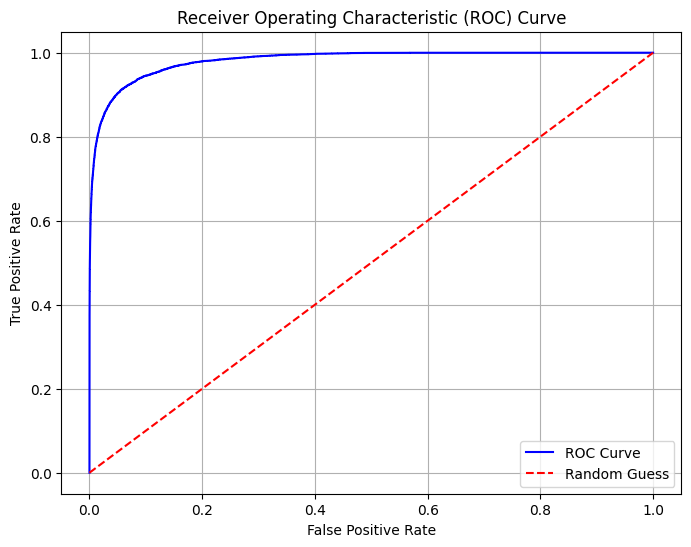

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [54]:
cl_report = multilabel_confusion_matrix(all_labels, all_predictions)
print("Classification report:")
print(len(cl_report))

Classification report:
156


In [55]:
print(cl_report[100])

[[7203    7]
 [  44    6]]


In [56]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_predictions, zero_division=np.nan)

In [57]:
all_predictions.sum(axis=0)

array([ 50.,  69.,  67.,  85.,  67.,  99.,  42.,  74.,  54.,  49.,  19.,
        59.,  44.,  40.,  77.,  75.,  75.,  94.,  46.,  97.,  72.,  71.,
        92., 115.,  60.,  55., 119.,  42.,  46.,  82.,  23., 115.,  54.,
        47.,  34., 103.,  53.,  33.,  46.,  77.,  70.,  37.,  49.,  43.,
        47.,  85.,  68.,  99.,  66.,  87.,  14.,  31.,  68.,  39., 105.,
        49.,   0.,   0.,  81.,  60.,  19., 162.,  62.,  63., 124.,  59.,
       145.,  74.,  55.,  45.,  54.,  98., 111.,  65.,  34.,  54.,  88.,
        79., 154.,  60., 130.,  67.,  92., 110.,  79.,  87.,  87.,  25.,
        44.,  45.,  81., 103.,  64.,  49., 122.,  26.,   9., 109.,  92.,
        72.,  13.,  50.,  42.,  16.,  40.,  42., 106., 160.,  30.,  98.,
       167.,  90.,  46.,  67.,  82.,  27.,   1.,  38.,  59., 108.,  40.,
        43.,  48., 103.,  68.,  61.,  76.,  82.,  38.,  40.,  13.,  13.,
        17.,  68.,  41.,  17.,  40.,  41., 106., 114.,  42.,  68.,  60.,
       123.,  65.,  17.,  66.,  71.,  95.,  66.,  3

In [58]:
print(report)

              precision    recall  f1-score   support

           0       0.70      0.35      0.47        99
           1       0.19      0.23      0.21        57
           2       0.61      0.82      0.70        50
           3       0.61      0.52      0.56       100
           4       0.72      0.48      0.57       100
           5       0.76      0.75      0.75       100
           6       0.33      0.28      0.30        50
           7       0.81      0.80      0.81        75
           8       0.41      0.44      0.42        50
           9       1.00      0.98      0.99        50
          10       0.26      0.10      0.14        50
          11       0.76      0.90      0.83        50
          12       1.00      1.00      1.00        44
          13       1.00      1.00      1.00        40
          14       0.65      1.00      0.79        50
          15       0.85      0.76      0.81        84
          16       0.60      0.90      0.72        50
          17       0.79    

In [ ]:
list(enc.classes_)[36]

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
num_classes = 83
# Compute precision, recall, and thresholds for each class
precision = dict()
recall = dict()
thresholds = dict()
average_precision = dict()

for i in range(num_classes):  # num_classes is the number of classes
    precision[i], recall[i], thresholds[i] = precision_recall_curve(all_labels[:, i], all_predictions[:, i])
    average_precision[i] = average_precision_score(all_labels[:, i], all_predictions[:, i])

# Compute micro-average precision-recall curve and AUC
precision["micro"], recall["micro"], _ = precision_recall_curve(all_labels.ravel(), all_predictions.ravel())
average_precision["micro"] = average_precision_score(all_labels, all_predictions, average="micro")

# Compute ROC curve and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_predictions[:, i])
    roc_auc[i] = roc_auc_score(all_labels[:, i], all_predictions[:, i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels.ravel(), all_predictions.ravel())
roc_auc["micro"] = roc_auc_score(all_labels, all_predictions, average="micro")

# Split classes into groups of 10
class_groups = [list(range(i, min(i + 10, num_classes))) for i in range(0, num_classes, 10)]

# Plot Precision-Recall and ROC curves for each group
for group in class_groups:
    plt.figure(figsize=(12, 6))

    # Plot Precision-Recall curve
    plt.subplot(1, 2, 1)
    plt.step(recall['micro'], precision['micro'], where='post', label='Micro-average Precision-Recall curve (AUPR = {0:0.2f})'
                 ''.format(average_precision["micro"]))
    for i in group:
        plt.step(recall[i], precision[i], where='post', label='Precision-recall curve of class {0} (AUPR = {1:0.2f})'
                 ''.format(i, average_precision[i]))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve (Classes {})'.format(group))
    plt.legend(loc="best")

    # Plot ROC curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr['micro'], tpr['micro'], label='Micro-average ROC curve (AUC = {0:0.2f})'
                 ''.format(roc_auc["micro"]))
    for i in group:
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (AUC = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Classes {})'.format(group))
    plt.legend(loc="best")

    plt.tight_layout()
    plt.show()


In [ ]:
import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))